In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk and -spacex) (lang:en) -is:retweet',
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-08-16T13:42:28Z'

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 5)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(2)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=1 and row['retweet_count']>=1 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-08-16T13:41:26.000Z,1427264239589371910,6.0,0.0,7.0,$HTSC is the most undervalued stock I own. #E...
1,2021-08-16T13:41:18.000Z,1427264206445989890,24.0,1.0,4.0,Chinese Tesla rival Nio narrows losses as reve...
2,2021-08-16T13:41:00.000Z,1427264131741147138,2.0,0.0,1.0,Tesla pushes new Full Self-Driving Beta update...
3,2021-08-16T13:40:41.000Z,1427264048203145216,7.0,1.0,4.0,@DogecoinNorway @itsALLrisky @Doge_France @nl_...
4,2021-08-16T13:40:22.000Z,1427263971292336133,10.0,0.0,5.0,New NHTSA announcement confirms 8th Autopilot-...
...,...,...,...,...,...,...
11938,2021-08-10T13:44:32.000Z,1425090690472685569,1.0,0.0,1.0,"Tesla Sold 32,968 China-Made Vehicles in July ..."
11939,2021-08-10T13:44:31.000Z,1425090687083728901,1.0,1.0,1.0,Tesla reportedly gets India to consider slashi...
11940,2021-08-10T13:44:31.000Z,1425090686550822913,4.0,0.0,1.0,"In early morning options action, equity names ..."
11941,2021-08-10T13:44:28.000Z,1425090673099825165,8.0,0.0,1.0,Nikola Wireless will be gifted to one of the c...


In [9]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      + timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d')) #%H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    if sentence.labels[0].value == 'NEGATIVE':
        probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
        binary.append(0)
    else:
        probs.append(sentence.labels[0].score)  # numerical score 0-1
        binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
df['probability'] = probs
df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

2021-08-16 14:50:30,778 loading file C:\Users\djlittle\.flair\models\sentiment-en-mix-distillbert_4.pt


,created_at,id,like_count,reply_count,retweet_count,text,text_clean,probability,sentiment,binary,Date
0,2021-08-16T13:41:26.000Z,1427264239589371910,6.0,0.0,7.0,$HTSC is the most undervalued stock I own. #E...,$HTSC is the most undervalued stock I own. #El...,0.998451,POSITIVE,1,2021-08-16
1,2021-08-16T13:41:18.000Z,1427264206445989890,24.0,1.0,4.0,Chinese Tesla rival Nio narrows losses as reve...,Chinese Tesla rival Nio narrows losses as reve...,-0.994230,NEGATIVE,0,2021-08-16
2,2021-08-16T13:41:00.000Z,1427264131741147138,2.0,0.0,1.0,Tesla pushes new Full Self-Driving Beta update...,Tesla pushes new Full Self-Driving Beta update...,-0.993257,NEGATIVE,0,2021-08-16
3,2021-08-16T13:40:41.000Z,1427264048203145216,7.0,1.0,4.0,@DogecoinNorway @itsALLrisky @Doge_France @nl_...,Come on Tesla accept doge already!!!,0.943296,POSITIVE,1,2021-08-16
4,2021-08-16T13:40:22.000Z,1427263971292336133,10.0,0.0,5.0,New NHTSA announcement confirms 8th Autopilot-...,New NHTSA announcement confirms 8th Autopilot-...,-0.999955,NEGATIVE,0,2021-08-16
...,...,...,...,...,...,...,...,...,...,...,...
11938,2021-08-10T13:44:32.000Z,1425090690472685569,1.0,0.0,1.0,"Tesla Sold 32,968 China-Made Vehicles in July ...","Tesla Sold 32,968 China-Made Vehicles in July ...",-0.905844,NEGATIVE,0,2021-08-10
11939,2021-08-10T13:44:31.000Z,1425090687083728901,1.0,1.0,1.0,Tesla reportedly gets India to consider slashi...,Tesla reportedly gets India to consider slashi...,-0.604204,NEGATIVE,0,2021-08-10
11940,2021-08-10T13:44:31.000Z,1425090686550822913,4.0,0.0,1.0,"In early morning options action, equity names ...","In early morning options action, equity names ...",-0.819552,NEGATIVE,0,2021-08-10
11941,2021-08-10T13:44:28.000Z,1425090673099825165,8.0,0.0,1.0,Nikola Wireless will be gifted to one of the c...,Nikola Wireless will be gifted to one of the c...,0.848928,POSITIVE,1,2021-08-10


In [10]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

tsla = yf.Ticker("TSLA")
tsla_stock = tsla.history(
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d'
        ).reset_index()
tsla_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300,0,0
1,2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600,0,0
2,2021-08-12,706.340027,722.799988,699.400024,722.250000,17459100,0,0
3,2021-08-13,723.710022,729.900024,714.340027,717.169983,16698900,0,0
4,2021-08-16,705.070007,709.500000,678.182617,686.169983,22671673,0,0


In [11]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d')) # %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300,0,0
1,2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600,0,0
2,2021-08-12,706.340027,722.799988,699.400024,722.250000,17459100,0,0
3,2021-08-13,723.710022,729.900024,714.340027,717.169983,16698900,0,0
4,2021-08-16,705.070007,709.500000,678.182617,686.169983,22671673,0,0


In [12]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,probability,binary
0,2021-08-10,48.163769,3.642737,8.157039,-0.101542,0.444195
1,2021-08-11,58.429552,4.258463,9.570906,-0.034130,0.485361
2,2021-08-12,77.394283,5.400588,10.213535,-0.108059,0.442623
3,2021-08-13,58.422192,4.146869,7.800184,0.006391,0.504144
4,2021-08-14,85.857935,5.025641,11.860014,0.103244,0.554401
5,2021-08-15,57.429551,3.666413,7.849200,0.108931,0.552171
6,2021-08-16,49.736132,3.479760,8.580210,-0.224806,0.383808


In [13]:
means['Date']

0    2021-08-10
1    2021-08-11
2    2021-08-12
3    2021-08-13
4    2021-08-14
5    2021-08-15
6    2021-08-16
Name: Date, dtype: object

In [14]:
tsla_stock['Date']

0    2021-08-10
1    2021-08-11
2    2021-08-12
3    2021-08-13
4    2021-08-16
Name: Date, dtype: object

In [15]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,reply_count,retweet_count,probability,binary,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-10,48.163769,3.642737,8.157039,-0.101542,0.444195,713.989990,716.590027,701.880005,709.989990,13432300,0,0
1,2021-08-11,58.429552,4.258463,9.570906,-0.034130,0.485361,712.710022,715.179993,704.210022,707.820007,9800600,0,0
2,2021-08-12,77.394283,5.400588,10.213535,-0.108059,0.442623,706.340027,722.799988,699.400024,722.250000,17459100,0,0
3,2021-08-13,58.422192,4.146869,7.800184,0.006391,0.504144,723.710022,729.900024,714.340027,717.169983,16698900,0,0
4,2021-08-16,49.736132,3.479760,8.580210,-0.224806,0.383808,705.070007,709.500000,678.182617,686.169983,22671673,0,0


In [16]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

0.7048230229200112

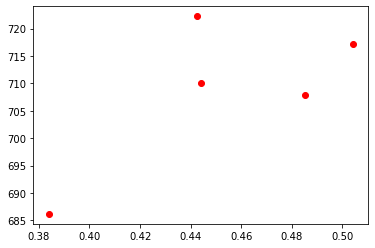

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [18]:
#import tweepy

#auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
#auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

#api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)